In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.optim as optim
import pickle
import torch.nn as nn
from nice.algorithms.connectivity_AT import *
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from torch.utils.data import DataLoader, TensorDataset
from scipy.ndimage import gaussian_filter1d
import gc

c:\Users\joshu\nice\.venv\Lib\site-packages\mne\externals\tempita\__init__.py:35: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


In [2]:
def smooth_with_gaussian(data, sigma=5):
    return gaussian_filter1d(data, sigma=sigma, axis=1) 

def preprocess(data):
    #data shape: (trials, time, neurons)
    trials, time, num_neurons = data.shape
    z = np.zeros_like(data)

    for neuron in range(num_neurons):
        for t in range(time):
            vals = data[:, t, neuron]  #this is all the data for given neuron at given time point
            std = np.std(vals)
            if std > 1e-6:
                z[:, t, neuron] = (vals - np.mean(vals)) / std    #zscore if there is a stdev
            else:
                z[:, t, neuron] = np.median(vals)   #returnt the median value otherwise  (median rather than mean in case of large variability in a singel point)

    if np.isnan(z).any():
        raise ValueError("Data contains NaN values after normalization.")

    return z

def get_shared_active_neurons(*arrays):
    combined_activity = np.zeros(arrays[0].shape[-1], dtype = bool)

    for arr in arrays:
        activity = arr.sum(axis = (0, 1)) != 0  
        combined_activity |= activity 

    return combined_activity


def get_data(file_number):
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    data = pickle.load(open(file_path, 'rb'))
  
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]  #for class of input
    attend_01 = data['attend'][0]
    omitted = data['omit'][0]
    relevant = np.where(omitted == 0)[0]
    left_inputs_SP = data['SP'][0][0][relevant]
    right_inputs_SP = data['SP'][0][1][relevant]
    attention_inputs_SP = data['SP'][0][2][relevant]
    #shapes 1057, 500, 160/80)

    left_sm = smooth_with_gaussian(left_inputs_SP) 
    right_sm = smooth_with_gaussian(right_inputs_SP) 
    att_sm = smooth_with_gaussian(attention_inputs_SP) 
 
    #preprocess here now that we have traces of all of the relavant trials
    left_input_proc = preprocess(left_sm)[:, 100:350, :]
    right_input_proc = preprocess(right_sm)[:, 100:350, :]
    attention_proc = preprocess(att_sm)[:, 100:350, :]

    left_indices_agg = np.where((omitted == 0) & (attend_01 == 0) & (label_left != label_right))[0]  #indices of agg where left
    print("relevant", relevant[0:20])
    print("left_indices_agg", left_indices_agg[0:20])
    _, left_indices, _ = np.intersect1d(relevant, left_indices_agg, return_indices = True)   #indices for relevant processed data where attention left
    print("left indices  ", left_indices[0:20])
    
    right_indices_agg = np.where((omitted == 0) & (attend_01 == 1) & (label_left != label_right))[0]
    print("relevant", relevant[0:20])
    print("right_indices_agg", right_indices_agg[0:20])
    _, right_indices, _ = np.intersect1d(relevant, right_indices_agg, return_indices = True)
    print("right indices  ", right_indices[0:20])

  

    left_attleft = left_input_proc[left_indices]
    left_attright = left_input_proc[right_indices]

    right_attleft = right_input_proc[left_indices]
    right_attright = right_input_proc[right_indices]
    
    att_attleft = attention_proc[left_indices]
    att_attright = attention_proc[right_indices]
  
  
    num_trials_left = len(left_indices)
    num_trials_right = len(right_indices)

    del data, left_input_proc, right_input_proc, attention_proc, left_indices, right_indices, left_indices_agg, right_indices_agg
    gc.collect()

    return left_attleft, left_attright, right_attleft, right_attright, att_attleft, att_attright, num_trials_left, num_trials_right
##e.g. dataset 1 gives left_attleft of shape (469 trials, 500 time points, 160 spikes)

l_al_data = []
l_ar_data = []
r_al_data = []
r_ar_data = []
a_al_data = []
a_ar_data = []

def collect_data(file_numbers):
    for file_number in file_numbers:
        left_attleft, left_attright, right_attleft, right_attright, att_attleft, att_attright, _, _, = get_data(file_number)
        l_al_data.append(left_attleft)
        l_ar_data.append(left_attright)
        r_al_data.append(right_attleft)
        r_ar_data.append(right_attright)
        a_al_data.append(att_attleft)
        a_ar_data.append(att_attright)
       
    return l_al_data, l_ar_data, r_al_data, r_ar_data, a_al_data, a_ar_data



In [3]:
#file_numbers = [1, 2, 4, 8, 14, 15, 20, 23] #for the full dataset
_, l_ar, _, r_ar, _, a_ar = collect_data(file_numbers = [1, 2, 4])

relevant [ 0  1  4  6 11 14 16 19 21 23 24 25 27 28 29 31 32 35 37 38]
left_indices_agg [ 0  1  4 16 23 24 25 27 28 29 32 35 38 52 57 59 60 61 65 67]
left indices   [ 0  1  2  6  9 10 11 12 13 14 16 17 19 24 27 29 30 31 34 35]
relevant [ 0  1  4  6 11 14 16 19 21 23 24 25 27 28 29 31 32 35 37 38]
right_indices_agg [ 6 11 14 19 31 37 41 47 51 54 56 58 64 68 76 78 82 83 85 90]
right indices   [ 3  4  5  7 15 18 20 21 23 25 26 28 33 36 38 39 41 42 43 46]
relevant [ 0  1  4 12 13 15 18 21 23 24 25 26 28 30 31 32 33 37 39 40]
left_indices_agg [ 0 18 24 25 26 28 30 31 37 40 52 56 61 65 68 70 78 81 84 96]
left indices   [ 0  6  9 10 11 12 13 14 17 19 24 26 29 32 34 35 37 38 39 45]
relevant [ 0  1  4 12 13 15 18 21 23 24 25 26 28 30 31 32 33 37 39 40]
right_indices_agg [ 1  4 12 13 15 21 23 33 39 41 46 51 55 57 59 63 66 75 86 89]
right indices   [ 1  2  3  4  5  7  8 16 18 20 22 23 25 27 28 31 33 36 40 41]
relevant [ 3  5  8 10 11 12 18 19 21 24 26 27 29 30 31 36 37 38 40 41]
left_indices_agg 

want to now make this into the appropriate input vector for MVPA
x will have n_total_trial inputs, each vector will have one of the 80 or 160 neurons as basis vector, and values of those vectors at each time point, e.g. 500 vectors each of length (80, 1) 

the goal will be to train 4 models
left input x predicting attention y when attention is left
right input x when predicting attention y when attention is right
"" same but for attention right

can then compare the r^2, mean square error, model weights, feature importance etc

will need [trials, n_features]

will be good to just shuffle the data and analyse the null distribution

In [4]:
def prep_data(x, y, batch_size = 16, shuffle = True):
    x = np.concatenate(x, axis = 0)
    y = np.concatenate(y, axis = 0)
    print(x.shape)
    print(y.shape)
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    print(x.shape)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)
    x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.2, random_state=42, shuffle=True)

    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True, num_workers=0)
    return train_loader, x_test, y_test, x_validation, y_validation

class SpikingAttentionLSTM(nn.Module):
    def __init__(self, input_dim = 160, hidden_dim = 128, output_dim = 80, num_layers = 2, dropout = 0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size = input_dim,
            hidden_size = hidden_dim, 
            batch_first = True,
            num_layers = num_layers,
            dropout = dropout if num_layers > 1 else 0.0,  #dropout only applies if num_layers > 1

        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)  # Dropout layer

    def forward(self, x):
        output, _ = self.lstm(x) #shape (batch_size, 500, hidden_dim)
        dropped = self.dropout(output)  #applies dropout to the LSTM output
        out = self.fc(dropped)
        return out   #this will be shape (batch_size, 500, 80)
    
class SpikingAttentionSkipConnection(nn.Module):
    def __init__(self, input_dim=160, hidden_dim=128, output_dim=80, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim + input_dim, output_dim)  #skip connection
     

    def forward(self, x):
        lstm_out, _ = self.lstm(x)             #(batch, time, hidden)
        concat = torch.cat([lstm_out, x], dim=-1)  #(batch, time, hidden + input)
        output = self.fc(concat)               #(batch, time, output)
        return output


def correlation_loss(pred, target):
    vx = pred - pred.mean(dim=1, keepdim=True)
    vy = target - target.mean(dim=1, keepdim=True)
    corr = (vx * vy).mean(dim=1) / (vx.std(dim=1) * vy.std(dim=1) + 1e-6)
    return 1 - corr.mean()

mse_loss = nn.MSELoss()

def combined_loss(pred, target, alpha=0.8):
    return alpha * correlation_loss(pred, target) + (1 - alpha) * mse_loss(pred, target)


def train(model, train_loader, x_val, y_val, 
           criterion, epochs=1000, clip_value = 1.0, 
           lr = 0.001, patience = 20):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    loss_history = []
    validation_loss_history = []

    best_val_loss = float('inf')
    best_model_state = None
    epochs_since_improvement = 0

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)  #gradient clipping
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)

        model.eval()
        with torch.no_grad():
            y_val_pred = model(x_val)
            val_loss = criterion(y_val_pred, y_val)
            val_loss_item = val_loss.item()
            validation_loss_history.append(val_loss.item())

        #early stopping
        if val_loss_item < best_val_loss:
            best_val_loss = val_loss_item
            best_model_state = model.state_dict()
            epochs_since_improvement = 0
        else:
            epochs_since_improvement += 1

            

        if epoch % 2 == 0:
            clear_output(wait=True)  #clears the Jupyter output cell
            plt.figure(figsize=(10, 7))
            plt.plot(loss_history, label = 'Training Loss')
            plt.plot(validation_loss_history, label = 'Validation Loss')
            plt.legend()
            plt.xlim(0, epochs)
            plt.ylim(0, 0.7)
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Training Loss')
            plt.grid(True)
            plt.show()

        if epochs_since_improvement >= patience:
            print(f"Early stopping at epoch {epoch} with validation loss: {best_val_loss:.4f}")
            break
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return loss_history, validation_loss_history


def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='True', alpha=0.5)
    plt.plot(y_pred, label='Predicted', alpha=0.5)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

def show_stats(y_test, y_pred_trained):
    #this takes the mean across trials and neurons, and then calculates r2, rmse and perason 
    r2 = r2_score(y_test.mean(axis=(0, 2)), y_pred_trained.mean(axis=(0, 2)))
    rmse = np.sqrt(mean_squared_error(y_test.mean(axis=(0, 2)), y_pred_trained.mean(axis=(0, 2))))
    pearson_corr = np.corrcoef(y_test.mean(axis=(0, 2)), y_pred_trained.mean(axis=(0, 2)))[0, 1]
    print("Pearson correlation coefficient:", pearson_corr)
    print("R^2:", r2)
    print("RMSE:", rmse)


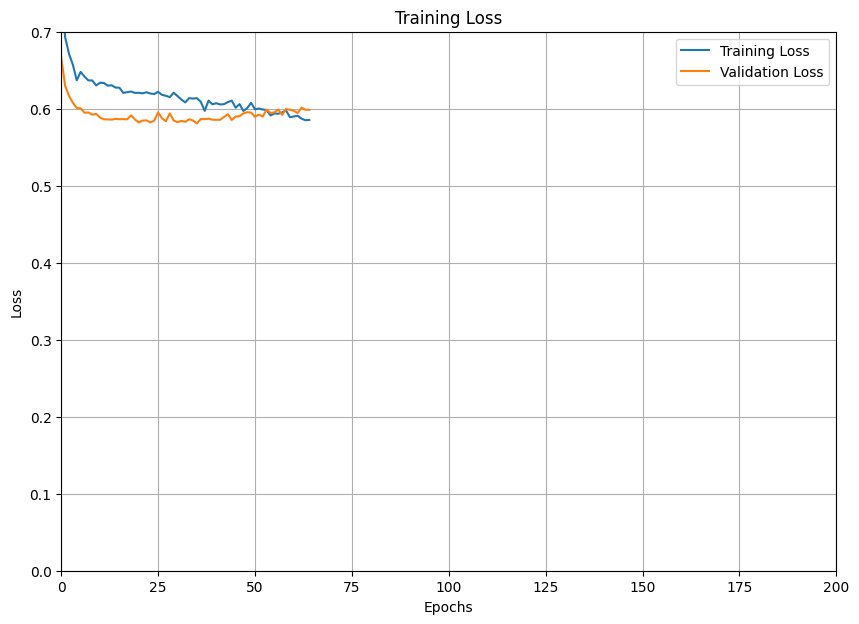

Early stopping at epoch 65 with validation loss: 0.5809
y_pred shape: (294, 250, 80)


In [5]:
#training loop
train_loader_left, x_test_left, y_test_left, x_validation_left, y_validation_left = prep_data(l_ar, a_ar, batch_size = 32, shuffle = True)

n_neurons_in = x_test_left.shape[2]
print('n_neurons:', n_neurons_in)
model_left = SpikingAttentionLSTM(input_dim = n_neurons_in, hidden_dim = 32, output_dim = 80, num_layers = 2, dropout = 0.3)

criterion = mse_loss
loss_history_left, validation_loss_history_left = train(model_left, train_loader_left, x_validation_left, y_validation_left,
                 criterion, epochs = 200, lr = 0.005, patience = 30)

y_pred_trained_l = model_left(x_test_left).detach().numpy()
print('y_pred shape:', y_pred_trained_l.shape)


this is overfitting - still working to resolve this

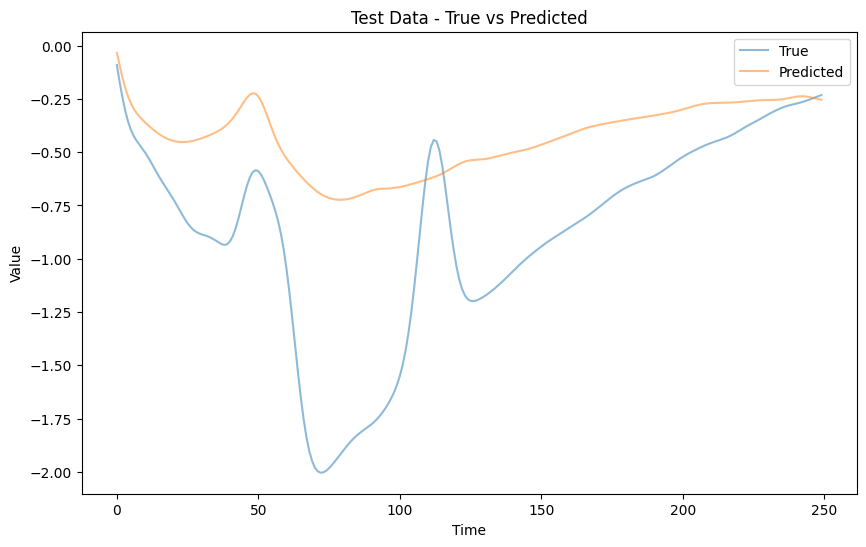

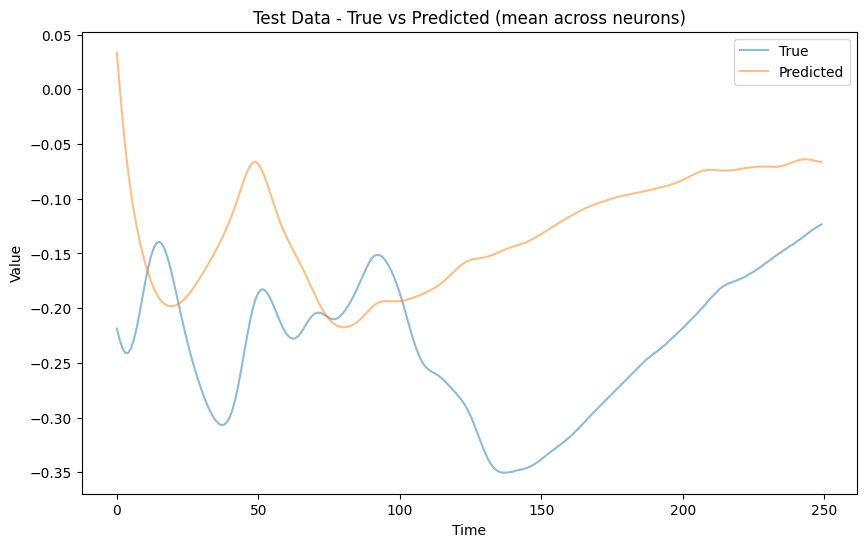

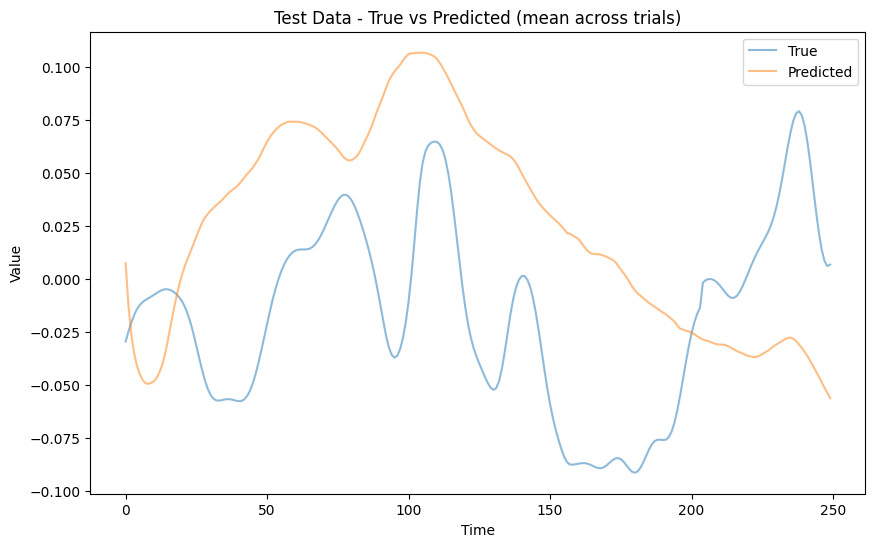

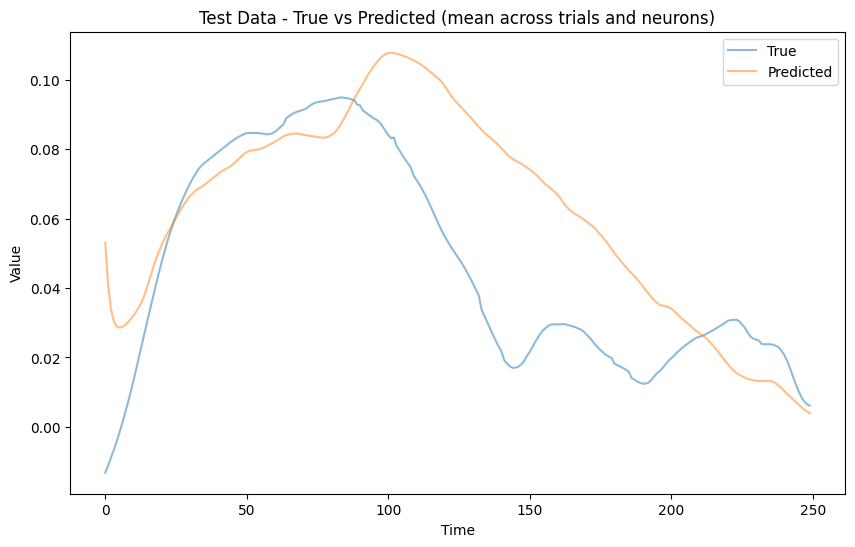

Pearson correlation coefficient: 0.7185039480712645
R^2: 0.19862037897109985
RMSE: 0.027285581


In [6]:
trial = 4
neuron = 2

plot_results(
    y_test_left[trial, :, neuron], y_pred_trained_l[trial, :, neuron],
    'Test Data - True vs Predicted'
)

plot_results(
    y_test_left[trial].mean(axis = 1), y_pred_trained_l[trial].mean(axis = 1),
    'Test Data - True vs Predicted (mean across neurons)'
)

plot_results(
    y_test_left[:, :, neuron].mean(axis = 0), y_pred_trained_l[:, :, neuron].mean(axis = 0),
    'Test Data - True vs Predicted (mean across trials)'
)

plot_results(
    y_test_left.mean(axis = (0, 2)), y_pred_trained_l.mean(axis = (0, 2)),
    'Test Data - True vs Predicted (mean across trials and neurons)'
)

show_stats(y_test_left, y_pred_trained_l)

In [7]:
print(len(r_ar), len(a_ar))

3 3


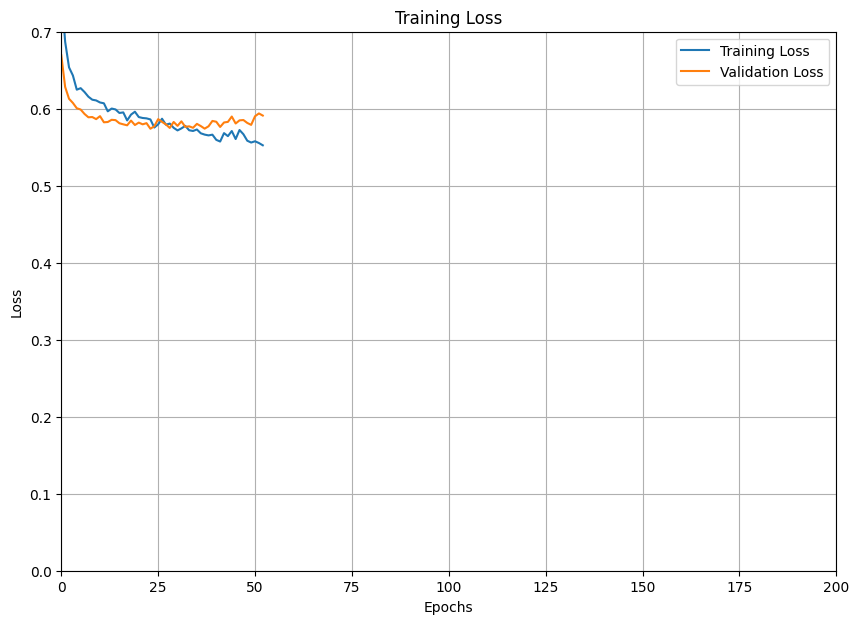

Early stopping at epoch 53 with validation loss: 0.5740
y_pred shape: (294, 250, 80)


In [8]:
train_loader_right, x_test_right, y_test_right, x_validation_right, y_validation_right = prep_data(r_ar, a_ar, batch_size=32, shuffle = True)

n_neurons_in = x_test_right.shape[2]
print('n_neurons:', n_neurons_in)
model_right = SpikingAttentionLSTM(input_dim = n_neurons_in, hidden_dim = 32, output_dim = 80, num_layers = 2, dropout = 0.3)

criterion = mse_loss
loss_history_right, validation_loss_history_right = train(model_right, train_loader_right, x_validation_right, y_validation_right,
                 criterion, epochs = 200, lr = 0.005, patience = 30)

y_pred_trained_r = model_right(x_test_right).detach().numpy()
print('y_pred shape:', y_pred_trained_r.shape)

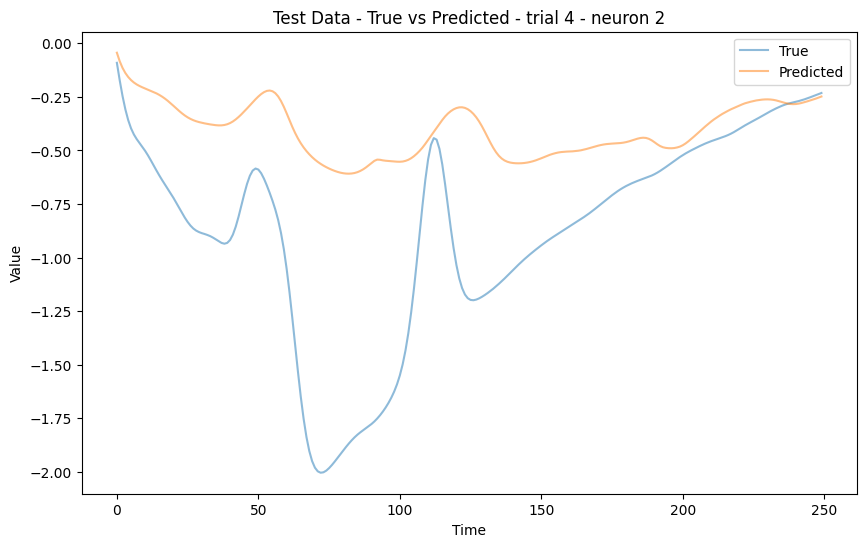

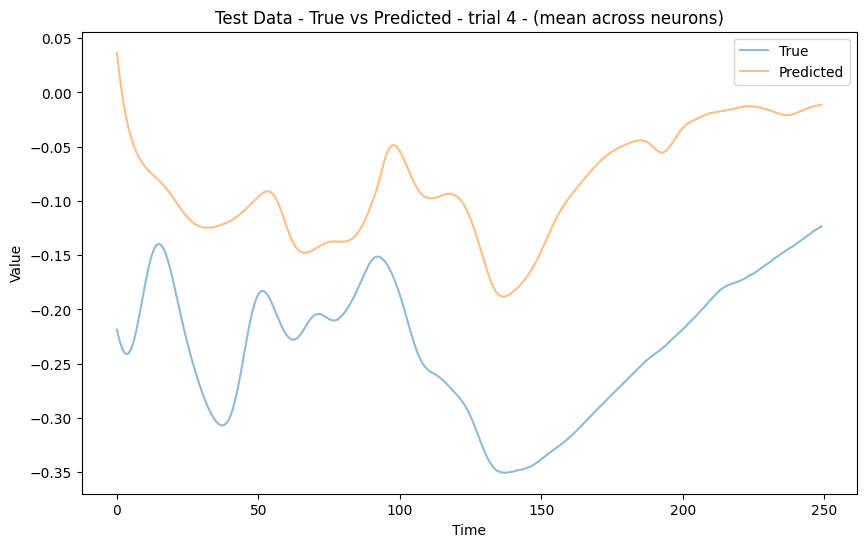

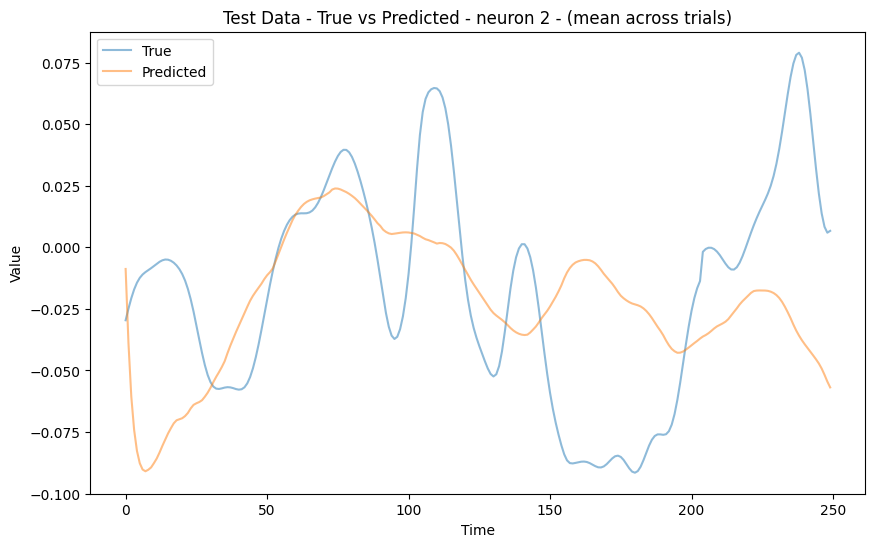

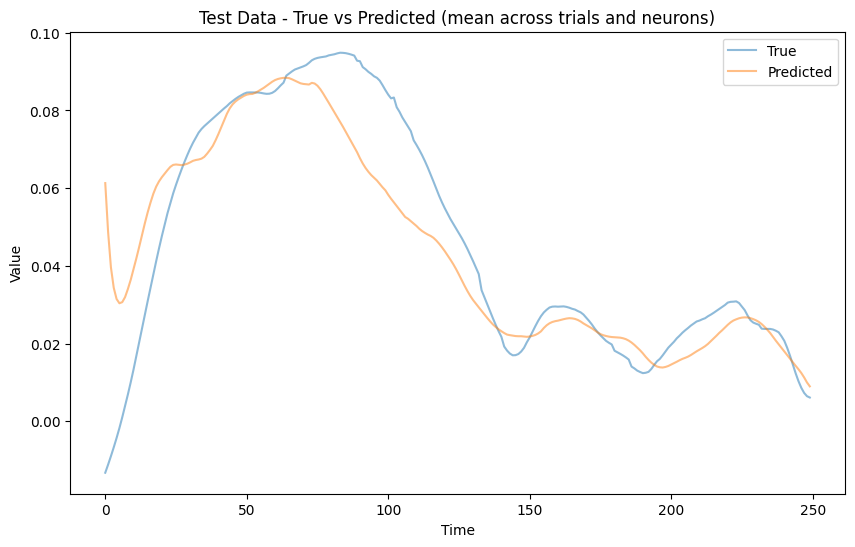

Pearson correlation coefficient: 0.896208295109271
R^2: 0.7918858528137207
RMSE: 0.013904804


In [9]:
trial = 4
neuron = 2

plot_results(
    y_test_right[trial, :, neuron], y_pred_trained_r[trial, :, neuron],
    f'Test Data - True vs Predicted - trial {trial} - neuron {neuron}'
)

plot_results(
    y_test_right[trial].mean(axis = 1), y_pred_trained_r[trial].mean(axis = 1),
    f'Test Data - True vs Predicted - trial {trial} - (mean across neurons)'
)

plot_results(
    y_test_right[:, :, neuron].mean(axis = 0), y_pred_trained_r[:, :, neuron].mean(axis = 0),
    f'Test Data - True vs Predicted - neuron {neuron} - (mean across trials)'
)

plot_results(
    y_test_right.mean(axis = (0, 2)), y_pred_trained_r.mean(axis = (0, 2)),
    'Test Data - True vs Predicted (mean across trials and neurons)'
)

show_stats(y_test_right, y_pred_trained_r)

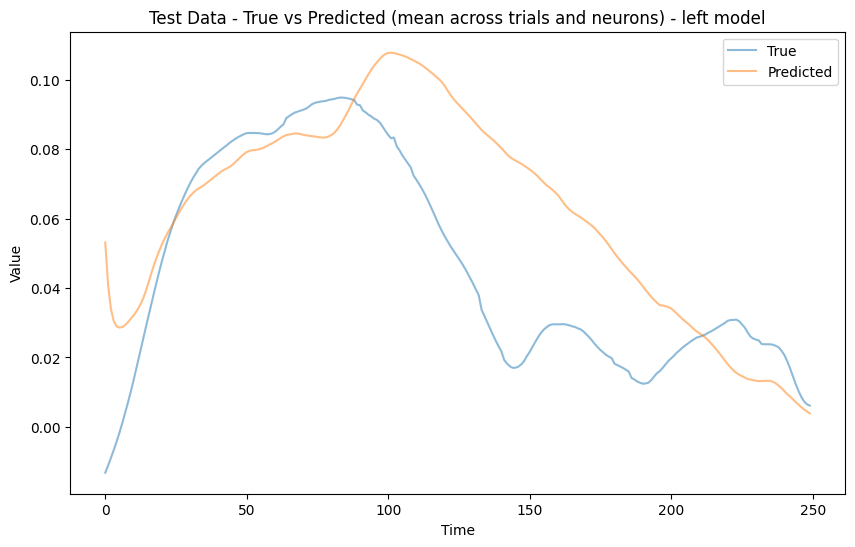

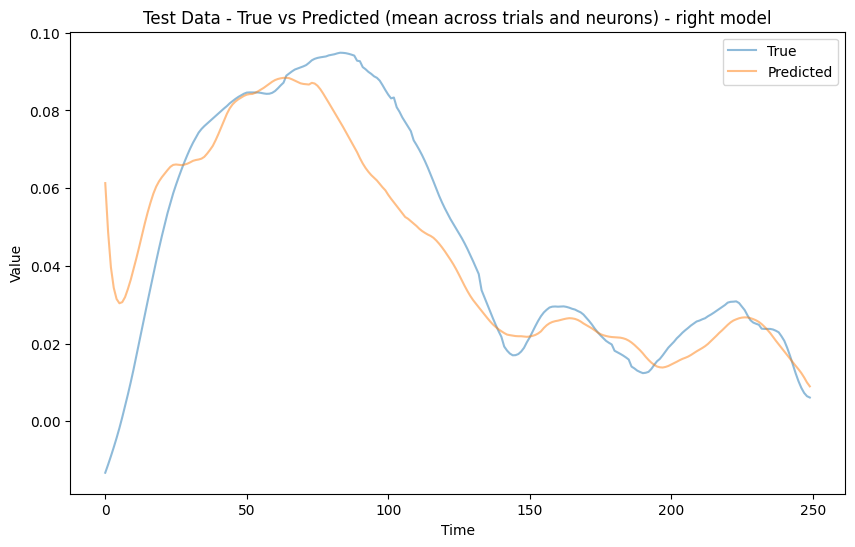

Pearson correlation coefficient: 0.7185039480712645
R^2: 0.19862037897109985
RMSE: 0.027285581
Pearson correlation coefficient: 0.896208295109271
R^2: 0.7918858528137207
RMSE: 0.013904804


In [11]:
plot_results(
    y_test_left.mean(axis = (0, 2)), y_pred_trained_l.mean(axis = (0, 2)),
    'Test Data - True vs Predicted (mean across trials and neurons) - left model'
)

plot_results(
    y_test_right.mean(axis = (0, 2)), y_pred_trained_r.mean(axis = (0, 2)),
    'Test Data - True vs Predicted (mean across trials and neurons) - right model'
)


show_stats(y_test_left, y_pred_trained_l)
show_stats(y_test_right, y_pred_trained_r)